## Tutorial \#3: Brains

<div style="text-align: justify; width: 75ch !important;">

<b><i>Spark</i></b> defines a very special module called <b>spark.nn.Brain</b>, this module has the sole purpose of constructing and running complex models. Moreover, this is where some of the optimizations that allow <b><i>Spark</i></b>'s models to run extremely fast happens. <br>
<br>
It all starts with the observation that in <b><i>Spark</i></b>, models are dynamical and, a few ideas down the line, we may think of computation as flows of information. Critically, flows are not immediate, this allows us to queue every single module contained in <b>Brain</b> for parallel update at the expense of a slightly larger memory footprint and a small latency; most neural models already incorporate delays anyway, what is another one extra timestep more. 

</div>

In [1]:
import sys
sys.path.insert(1, './..')

# Imports
import spark
import jax
import numpy as np
import typing as tp
import jax.numpy as jnp

In [2]:
brain_config = spark.nn.Config.from_file('./example_model.scfg')
brain = spark.nn.Brain(config=brain_config)

In [3]:
@jax.jit
def run_model(graph, state, x):
	model = spark.merge(graph, state)
	out = model(drive=x)
	_, state = spark.split((model))
	return out, state

@jax.jit
def retrieve_spikes(graph, state,):
	model = spark.merge(graph, state)
	spikes = model.get_spikes_from_cache()
	return spikes

def process_obs(x):
	# CartPos, CartSpeed, PoleAngle, PoleAngSpeed 
	x = x / np.array([2.4, 2.5, 0.2095, 3.5])
	x = np.clip(x, a_min=-1, a_max=1)
	return x

def compute_real_reward(x, x_prev, r_prev, terminated):
	# CartPos, CartSpeed, PoleAngle, PoleAngSpeed 
	if terminated:
		return 0
	r = (x_prev[0]**2 - x[0]**2) + (x_prev[2]**2 - x[2]**2)
	r = np.clip(0.5 * r_prev + 2 * r, a_min=-1, a_max=1)
	return r

In [6]:
import time
import gymnasium as gym
import ale_py
import numpy as np

from tqdm import tqdm
gym.register_envs(ale_py)

env_name =  'CartPole-v1'

env = gym.make(env_name)
next_obs, _ = env.reset(seed=42)
next_obs = process_obs(next_obs)

model = spark.nn.Brain(config=brain_config)
model(drive=spark.FloatArray(jnp.zeros((4,), dtype=jnp.float16)))
graph, state = spark.split((model))
#starting_kernel = model.neurons.synapses.get_flat_kernel()
brain_steps_per_env_step = 10

if True:
	reward = 0
	reward_array = []
	for i in tqdm(range(10000)):
		prev_obs = next_obs
		# Model logic
		out, state = run_model(graph, state, spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)))
		# Environment logic.
		next_action = int(np.argmax(out['integrator.signal'].value))
		next_obs, _, terminated, truncated, info = env.step(next_action)
		if terminated:
			next_obs, _ = env.reset()
			# Flush model
			for i in range(16):
				_, state = run_model(graph, state, spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)))
		next_obs = process_obs(next_obs)
		reward = compute_real_reward(next_obs, prev_obs, reward, terminated)
		reward_array.append(reward)

outs = []
spikes = []
obs = []
breaks = []
break_obs = []
actions = []
reward = 0
next_obs, _ = env.reset(seed=42+1)
next_obs = process_obs(next_obs)
for i in tqdm(range(100)):
	prev_obs = next_obs
	# Model logic
	for _ in range(brain_steps_per_env_step):
		out, state = run_model(graph, state, spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)))
		outs.append(out['integrator.signal'].value)
		model_spikes = retrieve_spikes(graph, state)
		spikes.append(
			jnp.concatenate([
				model_spikes['spiker'].value.reshape(-1),
				model_spikes['A_ex'].value.reshape(-1),
				model_spikes['A_in'].value.reshape(-1),
				model_spikes['B_ex'].value.reshape(-1),
				model_spikes['B_in'].value.reshape(-1),
			])
		)
		# Environment logic.
		next_action = int(np.argmax(out['integrator.signal'].value))
		actions.append(next_action)
	next_obs, _, terminated, truncated, info = env.step(next_action)
	if terminated:
		break_obs.append(next_obs)
		next_obs, _ = env.reset()
		breaks.append(brain_steps_per_env_step*i)
		# Flush model
		for i in range(50):
			_, state = run_model(graph, state, spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)))
	next_obs = process_obs(next_obs)
	reward = compute_real_reward(next_obs, prev_obs, reward, terminated)
	obs.append(next_obs)
	
model = spark.merge(graph, state)
spikes = np.abs(np.array(spikes))

100%|██████████| 100/100 [00:01<00:00, 98.49it/s]


NameError: name 'plt' is not defined

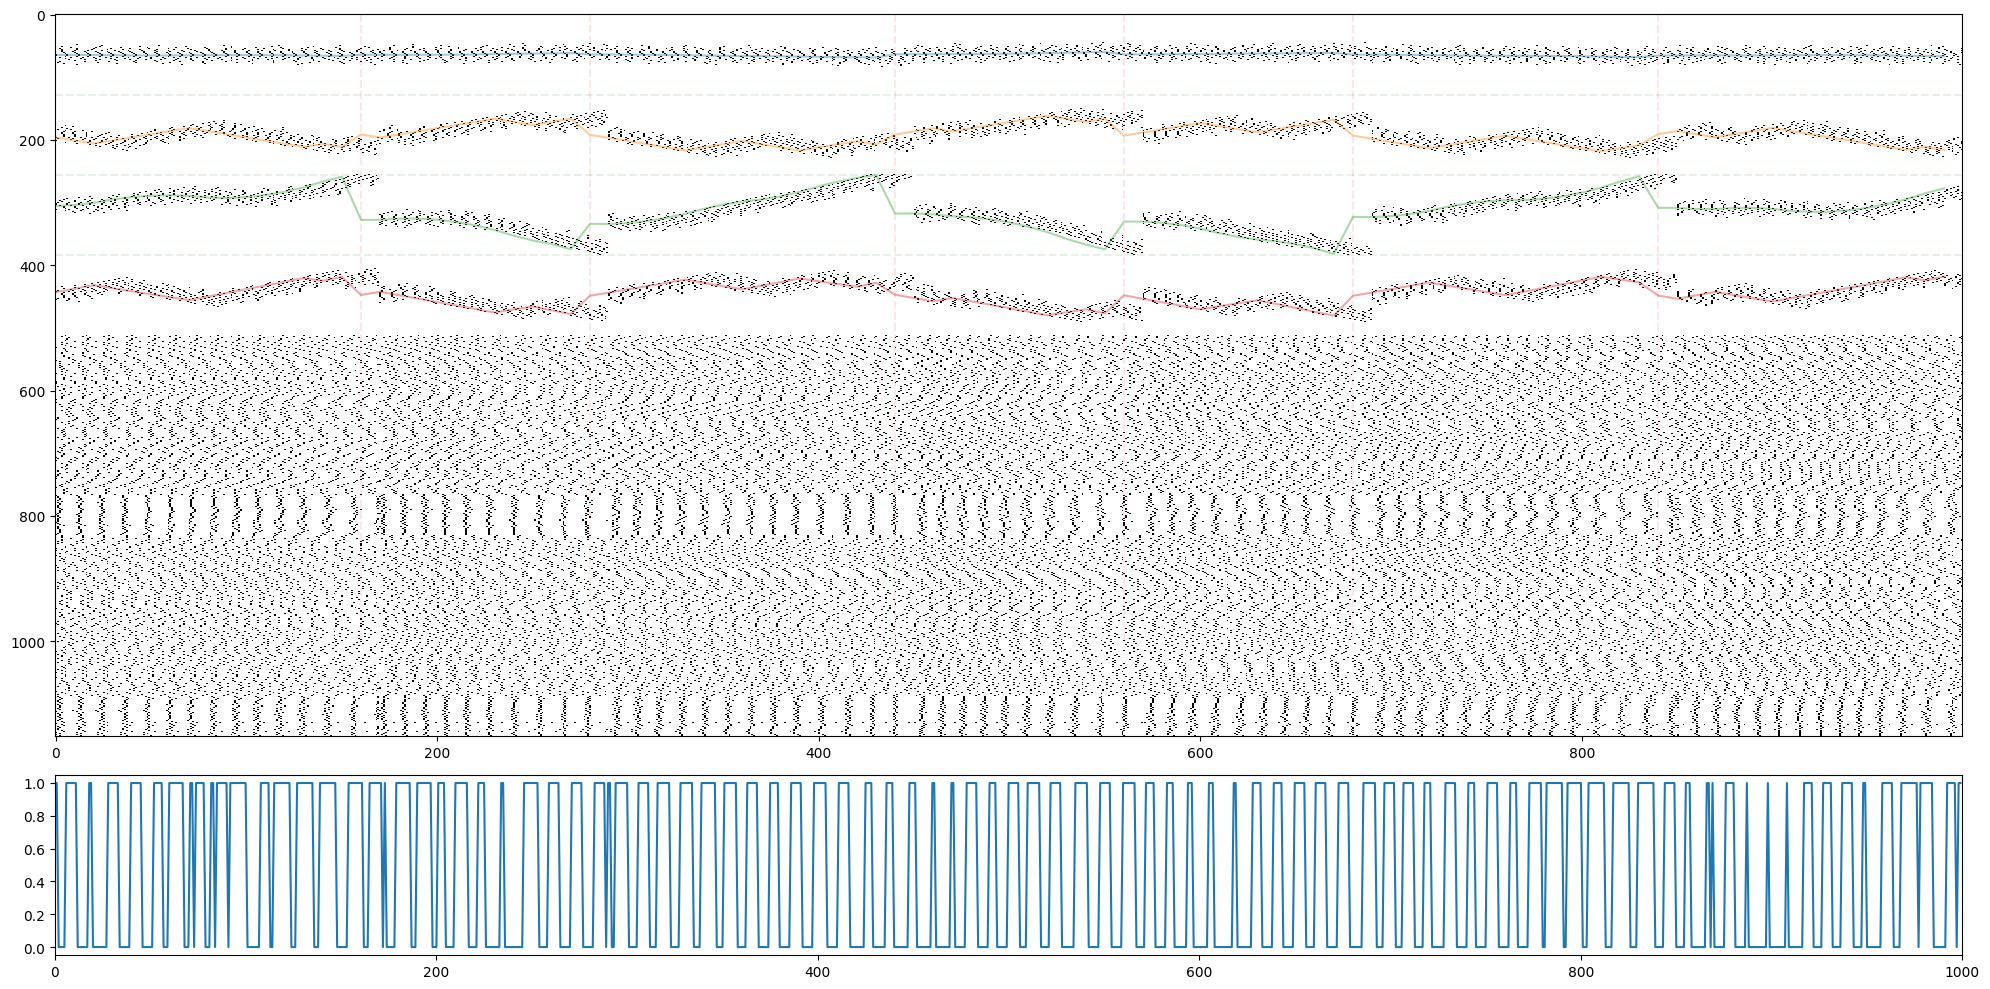

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1,figsize=(20,10), height_ratios=(8,2))
ax[0].imshow(1-spikes.T, cmap='gray', aspect='auto', interpolation='none')
for b in breaks:
    ax[0].plot([b,b], [0-0.5,len(spikes)-0.5], 'r--', alpha=0.1)
for i in range(3):
    ax[0].plot([0-0.5,len(spikes)-0.5], [128*(i+1), 128*(i+1)], 'g--', alpha=0.1)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[0]+64, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[1]+64+128, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[2]+64+256, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[3]+64+128+256, alpha=0.4)
ax[1].plot(actions)
ax[1].set_xlim(0, len(actions))
plt.tight_layout()
plt.show()
if False:
	plt.imshow(starting_kernel, aspect='auto', interpolation='none')
	plt.colorbar()
	plt.show()
	plt.imshow(final_kernel, aspect='auto', interpolation='none')
	plt.colorbar()
	plt.show()

In [8]:
# NOTE: Ignore this cell, this is just for formatting purposes.
from IPython.core.display import HTML
def css_styling():
    styles = open("./style.css", "r").read()
    return HTML(styles)
css_styling()